<a href="https://colab.research.google.com/github/DenuraTHEbest/InvestHere/blob/Amna_S/aspiFinal2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=ab8029b869988a154fd13334db7cf05aeae44435492527de7aaf95b7c67890c8
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Data: (602, 33), Testing Data: (151, 33)


<ipython-input-12-84967a017794>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data[f'Target_{i}'] = merged_data['Price'].shift(-i)
<ipython-input-12-84967a017794>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data[f'Target_{i}'] = merged_data['Price'].shift(-i)
<ipython-input-12-84967a017794>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

Model training completed.
MAE for day 1: 145.05034569536338
MAE for day 2: 182.24753642383985
MAE for day 3: 218.60619205297934
MAE for day 4: 255.5836225165548
MAE for day 5: 297.33692384105836
MAE for day 6: 332.232625827811
MAE for day 7: 370.11582715231384
MAE for day 8: 414.96399205297996
MAE for day 9: 395.8166562913886
MAE for day 10: 340.703357615893
MAE for day 11: 413.0939423841054
MAE for day 12: 423.68573642384104
MAE for day 13: 591.291621854305
MAE for day 14: 511.23986490066204
MAE for day 15: 430.0272145695355
MAE for day 16: 397.6674629139087
MAE for day 17: 446.8603370860942
MAE for day 18: 456.6989735099357
MAE for day 19: 459.12583841059694
MAE for day 20: 456.8814284768224
R2 for day 1: 0.9044791530977305
R2 for day 2: 0.8470313887037527
R2 for day 3: 0.7800416113900748
R2 for day 4: 0.7227932296343418
R2 for day 5: 0.6587138058982204
R2 for day 6: 0.601385119850373
R2 for day 7: 0.5111420458585689
R2 for day 8: 0.42409391789127726
R2 for day 9: 0.47129117444546775

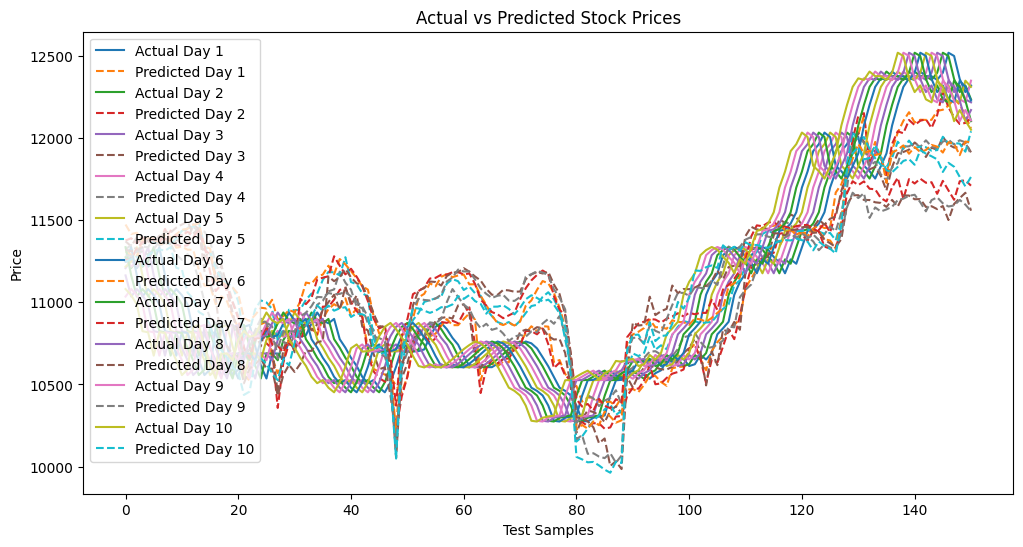

Feature columns (X): ['Date', 'Weighted_Sentiment', 'Lagged_Sentiment_1', 'Lagged_Sentiment_2', 'Lagged_Sentiment_3', 'Lagged_Sentiment_4', 'Lagged_Sentiment_5', 'Lagged_Sentiment_6', 'Lagged_Sentiment_7', 'Lagged_Sentiment_8', 'Lagged_Sentiment_9', 'Price_Lag1', 'Price_Lag2', 'Price_Lag3', 'Price_Lag4', 'Price_Lag5', 'Price_Lag6', 'Price_Lag7', 'Price_Lag8', 'Price_Lag9', 'Price_Lag10', 'Price_Lag12', 'Price_Lag15', 'Price_Lag18', 'Price_Lag20', 'Price_Lag25', 'Price_Lag30', 'EMA_7', 'EMA_14', 'EMA_30', 'MACD', 'MACD_Signal', 'MACD_Histogram']


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
import pandas as pd
from google.colab import drive
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import joblib
from ta.momentum import RSIIndicator
from ta.trend import MACD

# Mount Google Drive
drive.mount('/content/drive')

# Load datasets
aspi_data = pd.read_csv('/content/drive/My Drive/CSE_All_Share_Historical_Data_Processed.csv')
sentiment_data = pd.read_csv('/content/drive/My Drive/daily_weighted_scores_9-12.csv')

# Convert the Date columns to pandas datetime for both datasets
aspi_data['Date'] = pd.to_datetime(aspi_data['Date'])  # Already in YYYY-MM-DD format
sentiment_data['Date'] = pd.to_datetime(sentiment_data['Date'])  # Already in YYYY-MM-DD format

# Filter for the common date range
common_start_date = max(aspi_data['Date'].min(), sentiment_data['Date'].min())
common_end_date = min(aspi_data['Date'].max(), sentiment_data['Date'].max())

aspi_data = aspi_data[(aspi_data['Date'] >= common_start_date) & (aspi_data['Date'] <= common_end_date)]
sentiment_data = sentiment_data[(sentiment_data['Date'] >= common_start_date) & (sentiment_data['Date'] <= common_end_date)]

# Sort both datasets by date in ascending order
aspi_data = aspi_data.sort_values(by='Date')
sentiment_data = sentiment_data.sort_values(by='Date')

# Merge datasets with lagged sentiment features
for lag in range(1, 10):  # 9 days lag
    sentiment_data[f'Lagged_Sentiment_{lag}'] = sentiment_data['Weighted_Sentiment'].shift(lag)

# Drop rows with NaN values introduced by shifting
sentiment_data = sentiment_data.dropna(subset=[f'Lagged_Sentiment_{lag}' for lag in range(1, 10)])

# Merge the sentiment data with the ASPI data
merged_data = pd.merge(aspi_data[['Date', 'Price']], sentiment_data[['Date', 'Weighted_Sentiment'] + [f'Lagged_Sentiment_{lag}' for lag in range(1, 10)]],
                       on='Date', how='left')

# Create lagged price features (10, 20, 30 days)
for lag in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 18, 20, 25, 30]:
    merged_data[f'Price_Lag{lag}'] = merged_data['Price'].shift(lag)

# Calculate EMAs with different spans
merged_data['EMA_7'] = merged_data['Price'].ewm(span=7, adjust=False).mean()
merged_data['EMA_14'] = merged_data['Price'].ewm(span=14, adjust=False).mean()
merged_data['EMA_30'] = merged_data['Price'].ewm(span=30, adjust=False).mean()

# Calculate RSI with a 14-day window
#rsi = RSIIndicator(merged_data['Price'], window=14)
#merged_data['RSI_14'] = rsi.rsi()

# Drop rows with NaN values (from shifting and moving averages)
merged_data = merged_data.dropna()

# Create target variables for the next 20 days
for i in range(1, 21):
    merged_data[f'Target_{i}'] = merged_data['Price'].shift(-i)

# Remove rows with NaN values (from shifting)
merged_data = merged_data.dropna()

# Convert Date to numerical format (Unix timestamp)
merged_data['Date'] = merged_data['Date'].astype(np.int64) // 10**9  # Convert to Unix timestamp

# Compute MACD using 12, 26, and 9-day EMAs (default settings)
macd = MACD(merged_data['Price'])

# Add MACD components as features
merged_data['MACD'] = macd.macd()
merged_data['MACD_Signal'] = macd.macd_signal()
merged_data['MACD_Histogram'] = macd.macd_diff()

# Features (X) and Target (y)
X = merged_data.drop(columns=['Price'] + [f'Target_{i}' for i in range(1, 21)])
y = merged_data[[f'Target_{i}' for i in range(1, 21)]]

# Sort data by Date to ensure we train from oldest to newest
merged_data = merged_data.sort_values(by='Date')

# Split the data into train (80%) and test (20%) while preserving time order
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")

# Initialize and train Multi-Output RandomForestRegressor
base_model = RandomForestRegressor(n_estimators=100, random_state=42)
model = MultiOutputRegressor(base_model)
model.fit(X_train, y_train)

print("Model training completed.")

# Predict on test data
y_pred = model.predict(X_test)

# Evaluate model performance using Mean Absolute Error (MAE) for each day ahead
mae_scores = [mean_absolute_error(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Evaluate model performance using r2
r2_scores = [r2_score(y_test.iloc[:, i], y_pred[:, i]) for i in range(y_test.shape[1])]

# Print MAE and R2 results
for i, mae in enumerate(mae_scores, 1):
    print(f"MAE for day {i}: {mae}")

for i, r2 in enumerate(r2_scores, 1):
    print(f"R2 for day {i}: {r2}")

# Show predicted and actual values for the first 10 predictions
predicted_values = pd.DataFrame(y_pred, columns=[f'Predicted_{i}' for i in range(1, 21)])
actual_values = y_test.reset_index(drop=True)

# Extract the Date column from the merged_data DataFrame
dates = merged_data['Date'].iloc[split_index:].reset_index(drop=True)

# Merge the predicted and actual values with the Date column
comparison_df = pd.concat([dates, actual_values, predicted_values], axis=1)

# Display the first few rows for comparison
print(comparison_df.head(20))

# Optional: Plot Actual vs Predicted for the first 10 days of predictions
plt.figure(figsize=(12, 6))
for i in range(1, 11):
    plt.plot(comparison_df[f'Target_{i}'], label=f'Actual Day {i}')
    plt.plot(comparison_df[f'Predicted_{i}'], label=f'Predicted Day {i}', linestyle='--')

plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Test Samples')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

# Print the feature columns (X)
print("Feature columns (X):", X.columns.tolist())

# Save the trained model to a file
joblib.dump(model, 'aspi_forecast_model_new.pkl')
from google.colab import files
files.download('aspi_forecast_model_new.pkl')

#hyperparameter tuning with time series
#another model needs to be creating without RSI for better long term prediction. 5+ days. The RSI is commented out for the moment

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Select feature columns
feature_columns = ['Date', 'Weighted_Sentiment', 'Lagged_Sentiment_1', 'Lagged_Sentiment_2', 'Lagged_Sentiment_3',
                   'Lagged_Sentiment_4', 'Lagged_Sentiment_5', 'Lagged_Sentiment_6', 'Lagged_Sentiment_7',
                   'Lagged_Sentiment_8', 'Lagged_Sentiment_9', 'Price_Lag1', 'Price_Lag2', 'Price_Lag3',
                   'Price_Lag4', 'Price_Lag5', 'Price_Lag6', 'Price_Lag7', 'Price_Lag8', 'Price_Lag9',
                   'Price_Lag10', 'Price_Lag12', 'Price_Lag15', 'Price_Lag18', 'Price_Lag20', 'Price_Lag25',
                   'Price_Lag30', 'EMA_7', 'EMA_14', 'EMA_30', 'MACD', 'MACD_Signal', 'MACD_Histogram']

target_columns = [f'Target_{i}' for i in range(1, 21)]  # Target variables for next 20 days

# Prepare full dataset
full_data = merged_data[feature_columns + target_columns]

# Split 80% train, 20% test
train_data, test_data = train_test_split(full_data, test_size=0.2, shuffle=False)

# Save test data (only feature columns)
test_data_features = test_data[feature_columns]
test_data_features.to_csv('/content/drive/My Drive/aspi_test_features.csv', index=False)

print("✅ Test features saved successfully!")


✅ Test features saved successfully!


In [4]:
# Save the actual target values (y values)
test_data_targets = test_data[target_columns]
test_data_targets.to_csv('/content/drive/My Drive/aspi_test_targets.csv', index=False)

print("✅ Test target values saved!")


✅ Test target values saved!


In [5]:
files.download('/content/drive/My Drive/aspi_test_targets.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# Calculate directional accuracy
directional_accuracy = np.mean(np.sign(y_test) == np.sign(y_pred), axis=0)
for i, acc in enumerate(directional_accuracy, 1):
    print(f"Directional Accuracy for day {i}: {acc * 100:.2f}%")

Directional Accuracy for day 1: 100.00%
Directional Accuracy for day 2: 100.00%
Directional Accuracy for day 3: 100.00%
Directional Accuracy for day 4: 100.00%
Directional Accuracy for day 5: 100.00%
Directional Accuracy for day 6: 100.00%
Directional Accuracy for day 7: 100.00%
Directional Accuracy for day 8: 100.00%
Directional Accuracy for day 9: 100.00%
Directional Accuracy for day 10: 100.00%
Directional Accuracy for day 11: 100.00%
Directional Accuracy for day 12: 100.00%
Directional Accuracy for day 13: 100.00%
Directional Accuracy for day 14: 100.00%
Directional Accuracy for day 15: 100.00%
Directional Accuracy for day 16: 100.00%
Directional Accuracy for day 17: 100.00%
Directional Accuracy for day 18: 100.00%
Directional Accuracy for day 19: 100.00%
Directional Accuracy for day 20: 100.00%


Visualizations - MACD



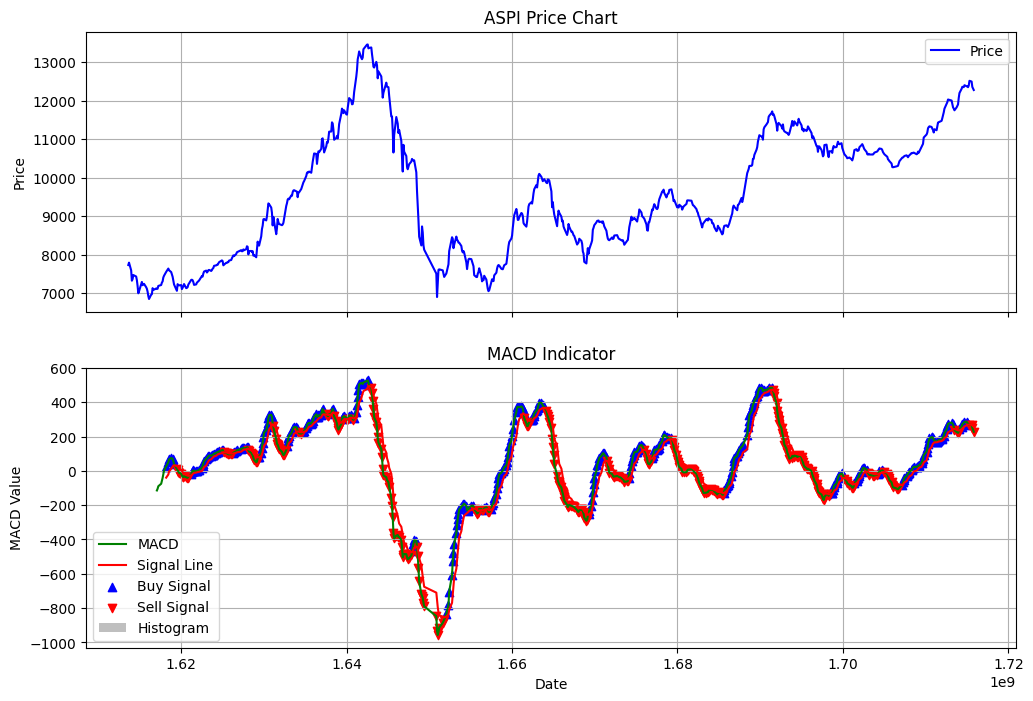

In [13]:
import matplotlib.pyplot as plt

# Create a figure with two subplots (Price & MACD)
fig, ax = plt.subplots(2, figsize=(12, 8), sharex=True)

# --- Price Chart ---
ax[0].plot(merged_data['Date'], merged_data['Price'], label='Price', color='blue')
ax[0].set_title('ASPI Price Chart')
ax[0].set_ylabel('Price')
ax[0].legend()
ax[0].grid()

# --- MACD & Signal Line ---
ax[1].plot(merged_data['Date'], merged_data['MACD'], label='MACD', color='green')
ax[1].plot(merged_data['Date'], merged_data['MACD_Signal'], label='Signal Line', color='red')
ax[1].bar(merged_data['Date'], merged_data['MACD_Histogram'], label='Histogram', color='gray', alpha=0.5)

# Highlight Buy/Sell signals
buy_signals = merged_data[merged_data['MACD'] > merged_data['MACD_Signal']]
sell_signals = merged_data[merged_data['MACD'] < merged_data['MACD_Signal']]

ax[1].scatter(buy_signals['Date'], buy_signals['MACD'], color='blue', label='Buy Signal', marker='^', alpha=1)
ax[1].scatter(sell_signals['Date'], sell_signals['MACD'], color='red', label='Sell Signal', marker='v', alpha=1)

ax[1].set_title('MACD Indicator')
ax[1].set_ylabel('MACD Value')
ax[1].legend()
ax[1].grid()

# Show the plot
plt.xlabel('Date')
plt.show()
